In [1]:
# Dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Data Preparation

In [2]:
df = pd.read_csv('crypto_data.csv')
df

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...,...
1247,XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [3]:
# Filter for currencies that are currently being traded
df = df[df['IsTrading'] == True]

df.drop('IsTrading', axis=1, inplace=True)

C:\Users\esalg\anaconda3\envs\pythondata\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# Remove all rows that have at least one null value
new_df = df.dropna()

In [5]:
# Filter for currencies that have more than 0 coins mined
new_df = new_df[new_df['TotalCoinsMined'] > 0]

In [6]:
# Remove columns with coin name
new_df.drop(columns=['CoinName', 'Unnamed: 0'], axis=1, inplace=True)

In [7]:
# Convert features with text values to numerical data
new_df = new_df.astype({'TotalCoinSupply': 'float64'})
numerical_df = pd.get_dummies(new_df)

In [8]:
numerical_df

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,2.000000e+09,2.000000e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1242,1.493105e+07,2.500000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1245,9.802226e+08,1.400223e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1246,7.296538e+06,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- From the original dataframe, 1252 rows were trimmed down to 532, and after inserting the dummy variables, the number of columns increased to 98.

In [9]:
# Standardize data
scaler = StandardScaler().fit(numerical_df)
data_scaled = scaler.transform(numerical_df)

data_scaled

array([[-0.11710817, -0.1528703 , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.09396955, -0.145009  , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [ 0.52494561,  4.48942416, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       ...,
       [-0.09561336, -0.13217937, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11694817, -0.15255998, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11710536, -0.15285552, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ]])

### Dimensionality Reduction

In [10]:
# Perform PCA while retaining 90% of the explained variance
pca = PCA(n_components=0.9, random_state=42)
data_pca = pca.fit_transform(data_scaled)

In [11]:
print(f"Number of features PRIOR PCA: {data_scaled.shape[1]}")
print(f"Number of features AFTER PCA: {data_pca.shape[1]}")

Number of features PRIOR PCA: 98
Number of features AFTER PCA: 74


In [12]:
# Reduce dimensions further with t-SNE
tsne = TSNE(learning_rate=250, random_state=0)
tsne_features = tsne.fit_transform(data_pca)

In [13]:
tsne_features.shape

(532, 2)

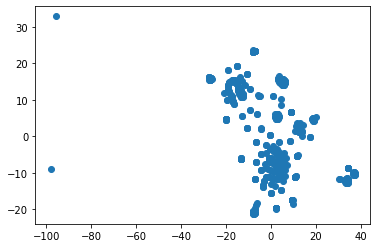

In [14]:
# Plot to see if there are clusters
plt.scatter(tsne_features[:, 0], tsne_features[:, 1])
plt.show()

### Cluster Analysis with k-Means

In [15]:
# Create an elbow plot to determine the best number of clusters
inertia = []
k = list(range(1,11))

for i in k:
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(tsne_features)
    inertia.append(model.inertia_)

C:\Users\esalg\anaconda3\envs\pythondata\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


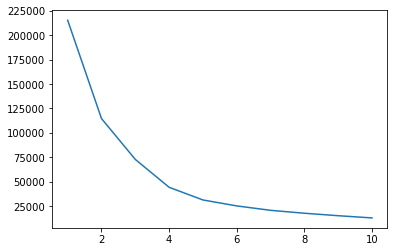

In [16]:
plt.plot(k, inertia)
plt.show()

- The elbow appears to be at k = 4.

In [17]:
# Use model with optimal k value to identify clusters
model = KMeans(n_clusters=4, random_state=42)
model.fit(tsne_features)

KMeans(n_clusters=4, random_state=42)

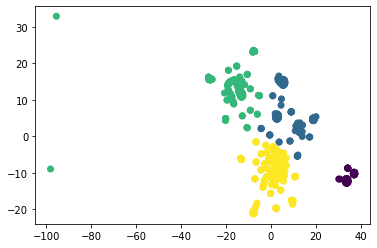

In [18]:
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=model.labels_)
plt.show()

### Recommendation

- Based on the elbow curve and the scatter plot, I would suggest that the cryptocurrecies can be separated into at least 4 fairly distinct groups. 
- It is worth noting that the purple cluster is smaller and more separated from the 3 main groups, and there are two outliers.